In [1]:
pip install kagglehub

In [2]:
!kaggle datasets download -d rm1000/brain-tumor-mri-scans

Dataset URL: https://www.kaggle.com/datasets/rm1000/brain-tumor-mri-scans
License(s): CC0-1.0
 97% 230M/236M [00:01<00:00, 166MB/s]
100% 236M/236M [00:01<00:00, 141MB/s]


In [3]:
!unzip /content/brain-tumor-mri-scans.zip -d /content/brain-tumor-mri-scans/


Streaming output truncated to the last 5000 lines.
  inflating: /content/brain-tumor-mri-scans/healthy/0402.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0403.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0404.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0405.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0406.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0407.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0408.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0409.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0410.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0411.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0412.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0413.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0414.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0415.jpg  
  inflating: /content/brain-tumor-mri-scans/healthy/0416.jpg  
  in

In [4]:
import os
dataset_path = '/content/brain-tumor-mri-scans/'

# List the folders inside the dataset directory
print(os.listdir(dataset_path))

['healthy', 'glioma', 'pituitary', 'meningioma']


In [5]:
from PIL import Image

image_dir = "/content/brain-tumor-mri-scans/"  # Change to the actual path

# Categories
categories = ["glioma", "healthy", "meningioma", "pituitary"]

# Function to check image integrity
def check_image_integrity(image_dir):
    corrupted_files = []
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        try:
            img = Image.open(img_path)
            img.verify()  # Verify if the image is readable
        except (IOError, SyntaxError) as e:
            corrupted_files.append(img_file)
    return corrupted_files

# Iterate through each category and check for corrupted images
for category in categories:
    category_path = os.path.join(image_dir, category)
    corrupted = check_image_integrity(category_path)
    if corrupted:
        print(f"Corrupted images in {category}: {corrupted}")
        # Remove corrupted files
        for corrupted_img in corrupted:
            os.remove(os.path.join(category_path, corrupted_img))
    else:
        print(f"No corrupted images in {category}")

No corrupted images in glioma
No corrupted images in healthy
No corrupted images in meningioma
No corrupted images in pituitary


In [6]:
import os
import cv2 as cv
import numpy as np

In [7]:
dir = 'brain-tumor-mri-scans'

images=[]
labels=[]
label_map = {'glioma': 0, 'healthy': 1, 'meningioma': 2, 'pituitary': 3}

for folder in os.listdir(dir):
    fol_path=os.path.join(dir,folder)
    print(folder)
    print(fol_path)
    for image in os.listdir(fol_path):
        img=cv.imread(os.path.join(fol_path,image)).astype('float32')
        img=cv.resize(img,(128,128))
        images.append(img)
        labels.append(folder)

healthy
brain-tumor-mri-scans/healthy
glioma
brain-tumor-mri-scans/glioma
pituitary
brain-tumor-mri-scans/pituitary
meningioma
brain-tumor-mri-scans/meningioma


In [8]:
#Conversion to Numpy Arrays

images = np.array(images)
labels = np.array(labels)

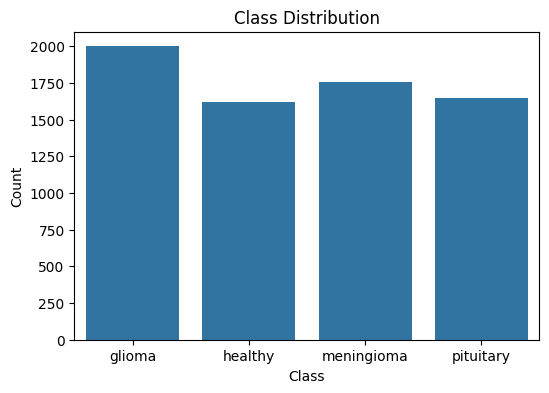

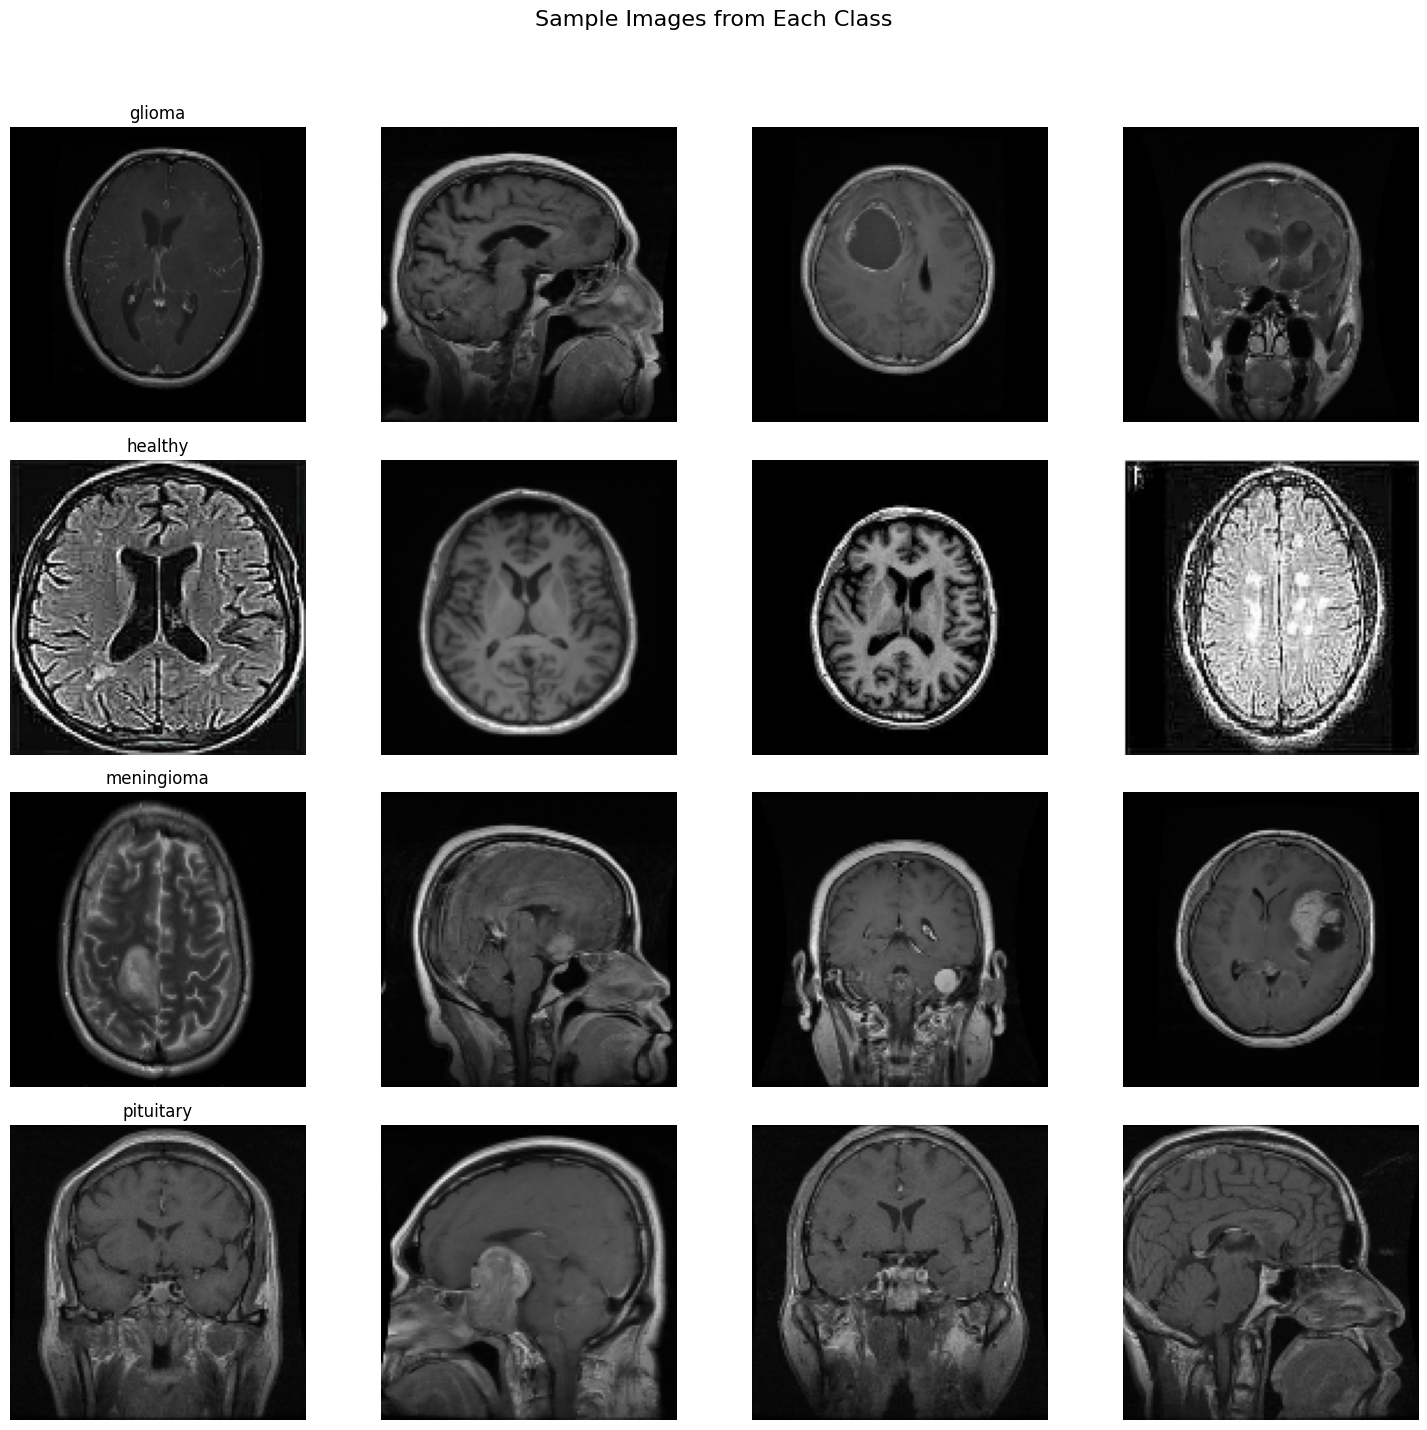

In [9]:
#Exploratory Data Visualization (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
import glob

# Parameters
IMG_SIZE = (128, 128)
batch_size = 32
EPOCHS = 10

plt.figure(figsize=(6, 4))
sns.countplot(x=labels)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(ticks=np.arange(4), labels=label_map.keys())
plt.show()

# Display 4 images from each class
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
fig.suptitle("Sample Images from Each Class", fontsize=16)

for row, (label_name, label) in enumerate(label_map.items()):
    sample_img_paths = glob.glob(os.path.join(dir, label_name, '*.jpg'))[:4]
    for col, img_path in enumerate(sample_img_paths):
        sample_img = cv.imread(img_path)
        sample_img = cv.cvtColor(sample_img, cv.COLOR_BGR2RGB)  # Convert color for accurate display
        axs[row, col].imshow(cv.resize(sample_img, IMG_SIZE))
        axs[row, col].set_title(label_name if col == 0 else "")
        axs[row, col].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [10]:
#Importing Libraries for ML Model and Classification

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, roc_curve, auc

In [11]:
# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [12]:
# Normalize and preprocess data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [13]:
# Load ResNet50 with ImageNet weights and remove the top layers
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Extract features from the images using ResNet50
X_train_features = base_model.predict(X_train)
X_test_features = base_model.predict(X_test)

# Flatten the extracted features for PCA
X_train_features_flat = X_train_features.reshape(X_train_features.shape[0], -1)
X_test_features_flat = X_test_features.reshape(X_test_features.shape[0], -1)

# Apply PCA
pca = PCA(n_components=50)
X_train_pca = pca.fit_transform(X_train_features_flat)
X_test_pca = pca.transform(X_test_features_flat)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
176/176 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step
44/44 ━━━━━━━━━━━━━━━━━━━━ 78s 2s/step


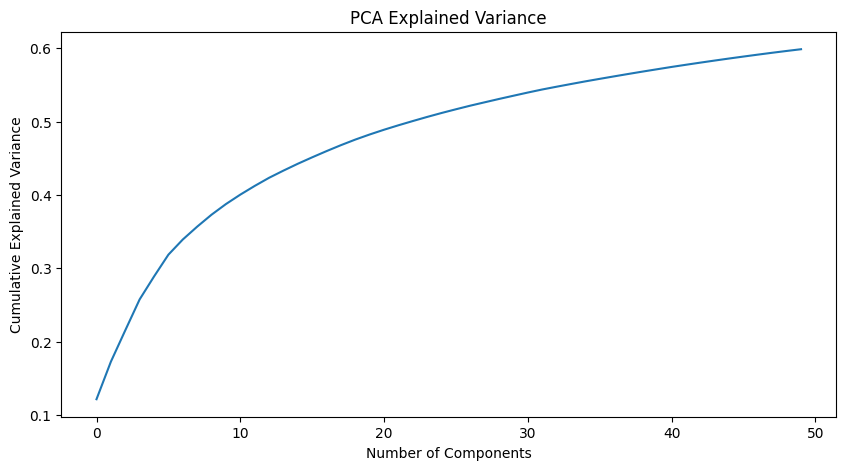

In [14]:
# Visualize explained variance to determine effectiveness of PCA
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA Explained Variance")
plt.show()

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Create a LabelEncoder object
label_encoder = LabelEncoder()

# Fit the encoder to the labels and transform them into numerical representations
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode labels
y_train_cat = to_categorical(y_train_encoded, num_classes=4)
y_test_cat = to_categorical(y_test_encoded, num_classes=4)

In [16]:
# Define the ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')
])

In [17]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time

# Adjust Input Size
input_shape = (128, 128, 3)

# Enhanced Data Augmentation
data_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = data_gen.flow(X_train, y_train_cat, batch_size=32)

# Compute Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Load ResNet50 with Pre-trained Weights
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False  # Freeze the base model

# Add Custom Layers on Top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(len(np.unique(y_train)), activation='softmax')  # Adjust output size
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Initial Training (Feature Extraction)
start_time = time.time()
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=(X_test, y_test_cat),
    steps_per_epoch=len(X_train) // 32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
print(f"Time for feature extraction training: {time.time() - start_time:.2f} seconds")

# Fine-Tuning (Unfreeze Some Layers)
base_model.trainable = True
for layer in base_model.layers[:-50]:  # Unfreeze the last 50 layers
    layer.trainable = False

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-Tuning Phase
start_time = time.time()
history = model.fit(
    train_generator,
    epochs=15,
    validation_data=(X_test, y_test_cat),
    steps_per_epoch=len(X_train) // 32,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)
print(f"Time for fine-tuning training: {time.time() - start_time:.2f} seconds")

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


175/175 ━━━━━━━━━━━━━━━━━━━━ 416s 2s/step - accuracy: 0.6001 - loss: 3.8644 - val_accuracy: 0.7374 - val_loss: 1.5201 - learning_rate: 0.0010
Epoch 2/15
  1/175 ━━━━━━━━━━━━━━━━━━━━ 4:19 1s/step - accuracy: 0.7812 - loss: 1.3967

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 471ms/step - accuracy: 0.7812 - loss: 1.3967 - val_accuracy: 0.7246 - val_loss: 1.5122 - learning_rate: 0.0010
Epoch 3/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.7517 - loss: 1.3235 - val_accuracy: 0.7046 - val_loss: 1.1555 - learning_rate: 0.0010
Epoch 4/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 471ms/step - accuracy: 0.7812 - loss: 1.0133 - val_accuracy: 0.7231 - val_loss: 1.1323 - learning_rate: 0.0010
Epoch 5/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 414s 2s/step - accuracy: 0.7607 - loss: 1.0255 - val_accuracy: 0.7402 - val_loss: 0.9614 - learning_rate: 0.0010
Epoch 6/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 83s 471ms/step - accuracy: 0.7500 - loss: 0.9700 - val_accuracy: 0.7203 - val_loss: 0.9986 - learning_rate: 0.0010
Epoch 7/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.7556 - loss: 0.9237 - val_accuracy: 0.7623 - val_loss: 0.8365 - learning_rate: 0.0010
Epoch 8/15
175/175 ━━━━━━━━━━━━━━━━━━━━ 84s 471ms/step - accuracy: 0.7500 - loss: 0.970

In [23]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score

# Predict on test data
y_test_pred = model.predict(X_test)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)
y_test_true_labels = np.argmax(y_test_cat, axis=1)

# Calculate Precision and Recall
precision = precision_score(y_test_true_labels, y_test_pred_labels, average='macro')
recall = recall_score(y_test_true_labels, y_test_pred_labels, average='macro')

# Calculate F1 Score
f1 = f1_score(y_test_true_labels, y_test_pred_labels, average='macro')

# Calculate ROC-AUC Score
roc_auc = roc_auc_score(y_test_cat, y_test_pred, multi_class="ovr", average="macro")

# Display metrics
print(f"Precision (Macro): {precision:.4f}")
print(f"Recall (Macro): {recall:.4f}")
print(f"F1 Score (Macro): {f1:.4f}")
print(f"ROC-AUC Score (Macro): {roc_auc:.4f}")

44/44 ━━━━━━━━━━━━━━━━━━━━ 76s 2s/step
Precision (Macro): 0.8460
Recall (Macro): 0.8004
F1 Score (Macro): 0.7974
ROC-AUC Score (Macro): 0.9783


Classification Report:

              precision    recall  f1-score   support

      Glioma       1.00      0.50      0.66       324
     Healthy       0.74      0.99      0.85       400
  Meningioma       0.80      0.80      0.80       329
   Pituitary       0.84      0.92      0.88       352

    accuracy                           0.81      1405
   macro avg       0.85      0.80      0.80      1405
weighted avg       0.84      0.81      0.80      1405



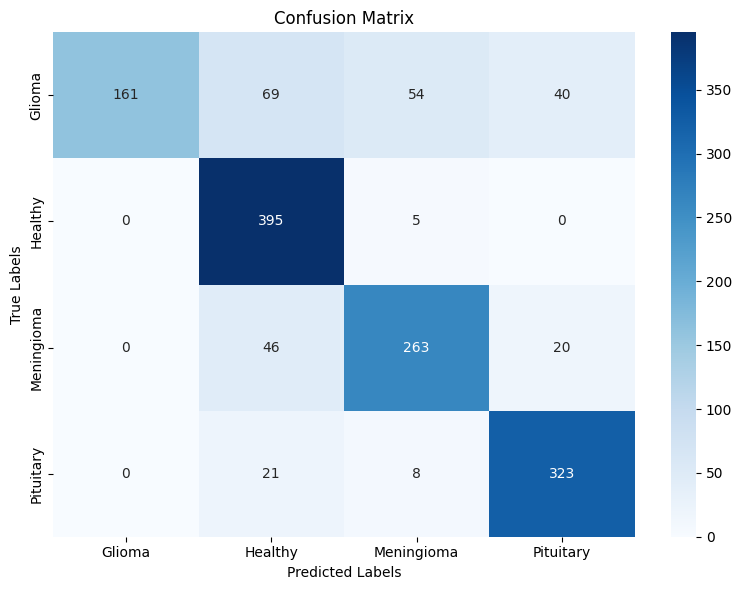

In [24]:
class_labels = ['Glioma', 'Healthy', 'Meningioma', 'Pituitary']

# Generate classification report
report = classification_report(y_test_true_labels, y_test_pred_labels, target_names=class_labels)
print("Classification Report:\n")
print(report)

# Confusion matrix
conf_matrix = confusion_matrix(y_test_true_labels, y_test_pred_labels)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

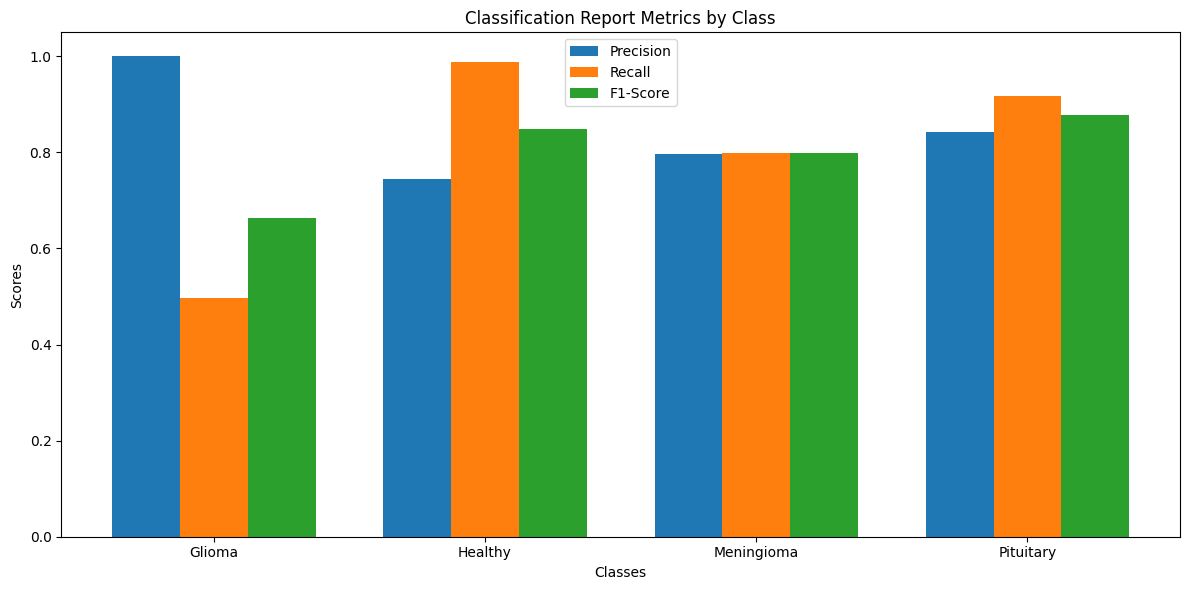

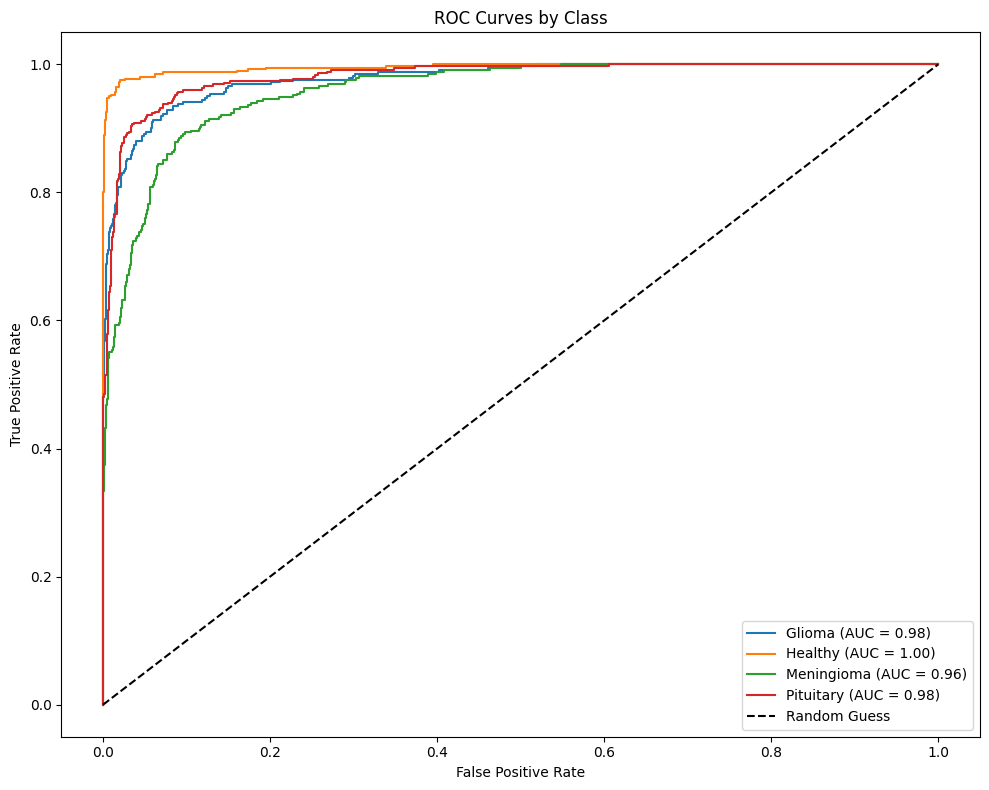

In [25]:
# Extract classification report metrics
report_dict = classification_report(y_test_true_labels, y_test_pred_labels, target_names=class_labels, output_dict=True)
precision_values = [report_dict[label]["precision"] for label in class_labels]
recall_values = [report_dict[label]["recall"] for label in class_labels]
f1_values = [report_dict[label]["f1-score"] for label in class_labels]

# Plot classification report metrics as a bar chart
x = np.arange(len(class_labels))
bar_width = 0.25

plt.figure(figsize=(12, 6))
plt.bar(x - bar_width, precision_values, bar_width, label="Precision")
plt.bar(x, recall_values, bar_width, label="Recall")
plt.bar(x + bar_width, f1_values, bar_width, label="F1-Score")

plt.xlabel("Classes")
plt.ylabel("Scores")
plt.title("Classification Report Metrics by Class")
plt.xticks(x, class_labels)
plt.legend()
plt.tight_layout()
plt.show()

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_labels):
    fpr, tpr, _ = roc_curve(y_test_cat[:, i], y_test_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves by Class")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()